In [245]:
import pandas as pd 
import numpy as np
import os
import pathlib 
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [246]:
def parseConfigData(config_string):
    # Define regular expressions for extracting data
    failures_pattern = r"Failures: (\d+\.\d+)%"
    cost_pattern = r"Experiment cost: \$([0-9.]+)"
    cpu_pattern = r"CPU: \[([\d., ]+)\]"
    mem_pattern = r"Mem: \[([\d., ]+)\]"
    func_args_pattern = r"Function argument\(s\): (.+)"

    # Initialize the dictionary to store extracted values
    config_data = {}

    # Extract and store Failures
    failures_match = re.search(failures_pattern, config_string)
    if failures_match:
        config_data["Failures"] = float(failures_match.group(1))

    # Extract and store Experiment cost
    cost_match = re.search(cost_pattern, config_string)
    if cost_match:
        config_data["Experiment Cost"] = float(cost_match.group(1))

    # Extract and store CPU values
    cpu_match = re.search(cpu_pattern, config_string)
    if cpu_match:
        config_data["CPU"] = [float(x.strip()) for x in cpu_match.group(1).split(',')]

    # Extract and store Mem values
    mem_match = re.search(mem_pattern, config_string)
    if mem_match:
        config_data["Mem"] = [float(x.strip()) for x in mem_match.group(1).split(',')]
        
    # Extract and store Function arguments
    func_args_match = re.search(func_args_pattern, config_string)
    if func_args_match:
        config_data["Function Arguments"] = func_args_match.group(1)

    return config_data

In [301]:
def sizeFromCount(count):
    return {
        19: "XL",
        14: "XL",
        10: "L",
        5: "M",
        3: "S"  
    }[count]

In [308]:
def readExp(path, n=9):
    with open(path) as file:
        head = [next(file) for _ in range(n)]
        df = pd.read_csv(file)
        
    res = parseConfigData("\n".join(head))
    best = df.iloc[0]
    res['bestTime'] = best.time
    res['funcName'] = str(path).split("_")[1]
    res['bestCost'] = best.cost
    res['best'] = best
    res['runSize'] = sizeFromCount(len(res['CPU']))
    res['df'] = df
    return res

In [309]:
resultsPath = "../FaaSterConfig/results/"

In [310]:
results = [x for x in sorted(pathlib.Path(resultsPath).iterdir(), key=os.path.getmtime)]
for path in results:
    print(os.path.basename(path))

FaaSterResults_matmul2_20231119-122643.csv
FaaSterResults_matmul2_20231119-124122.csv
FaaSterResults_image-processing_20231119-184711.csv
FaaSterResults_matmul2_20231119-160223.csv
FaaSterResults_image-processing_20231119-200655.csv
FaaSterResults_matmul2_20231119-192853.csv
FaaSterResults_matmul2_20231119-193345.csv
FaaSterResults_matmul2_20231119-193806.csv
FaaSterResults_matmul2_20231119-194514.csv
FaaSterResults_matmul2_20231119-194945.csv
FaaSterResults_matmul2_20231119-200224.csv
FaaSterResults_matmul2_20231119-211914.csv
FaaSterResults_openfaas-ocr_20231119-214216.csv
FaaSterResults_s3du_20231119-215250.csv
FaaSterResults_openfaas-ocr_20231119-215708.csv


In [311]:
exps = [readExp(r) for r in results]

In [312]:
exps

[{'Failures': 11.11,
  'Experiment Cost': 0.18050395647511114,
  'CPU': [0.25, 0.5, 1.0],
  'Mem': [248.0, 500.0, 15000.0],
  'Function Arguments': '1000',
  'bestTime': 0.515482,
  'funcName': 'matmul2',
  'bestCost': 4.732051067776151e-06,
  'best': CPU                 1.0
  Mem               500.0
  NodeTypeStr    c5.large
  time           0.515482
  cost           0.000005
  costPerHour    0.033047
  startupTime    4.502557
  timeAndCost    -0.91069
  Name: 0, dtype: object,
  'runSize': 'S',
  'df':      CPU      Mem NodeTypeStr      time      cost  costPerHour  startupTime  \
  0   1.00    500.0    c5.large  0.515482  0.000005     0.033047     4.502557   
  1   1.00    248.0    m5.large  0.544234  0.000005     0.031816     3.364532   
  2   1.00    500.0   c7g.large  0.604672  0.000005     0.028110     2.290338   
  3   1.00    248.0    c5.large  0.606817  0.000005     0.029779     3.411319   
  4   1.00    248.0   c7g.large  0.624784  0.000004     0.025330     3.536267   
  5   

In [306]:
exp = exps[-1]

In [253]:
# Set the style of seaborn for better aesthetics
sns.set(style="whitegrid")

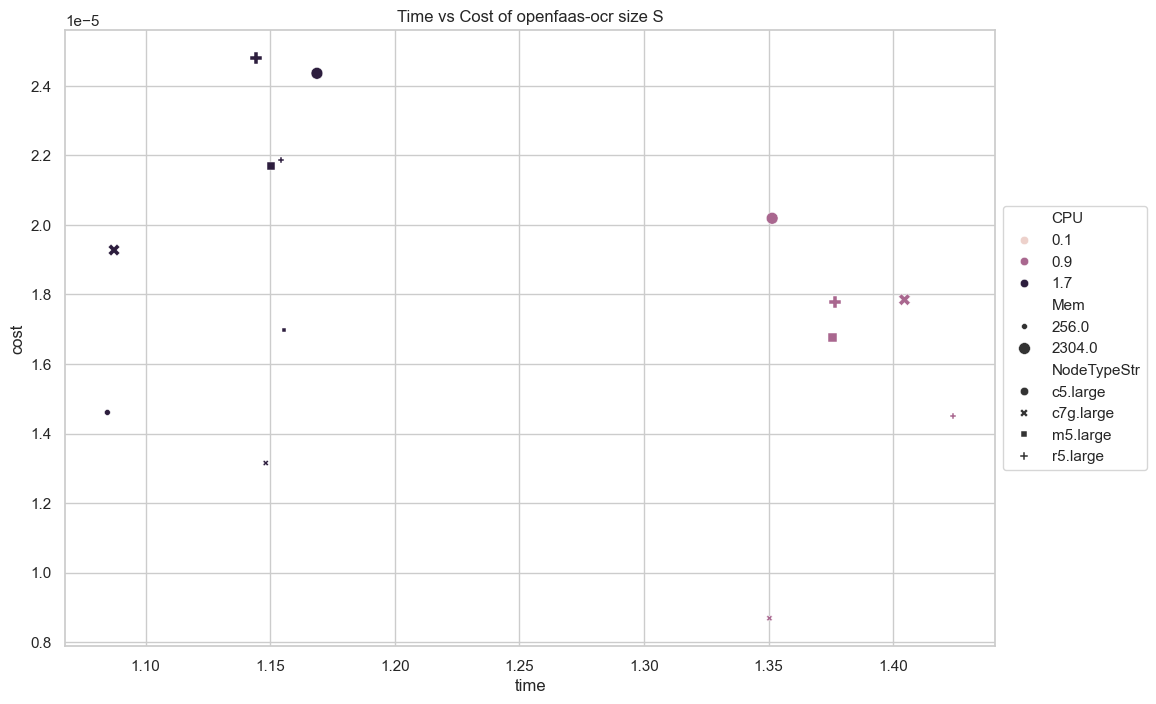

In [297]:
# Plot 1: time vs cost, colored by CPU, size of Mem, and shape of NodeType
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(x="time", y="cost", hue="CPU", size="Mem", style="NodeTypeStr", data=exp['df'])
scatter.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
scatter.set_title(f"Time vs Cost of {exp['funcName']} size {exp['runSize']}")
plt.show()

<Figure size 1200x800 with 0 Axes>

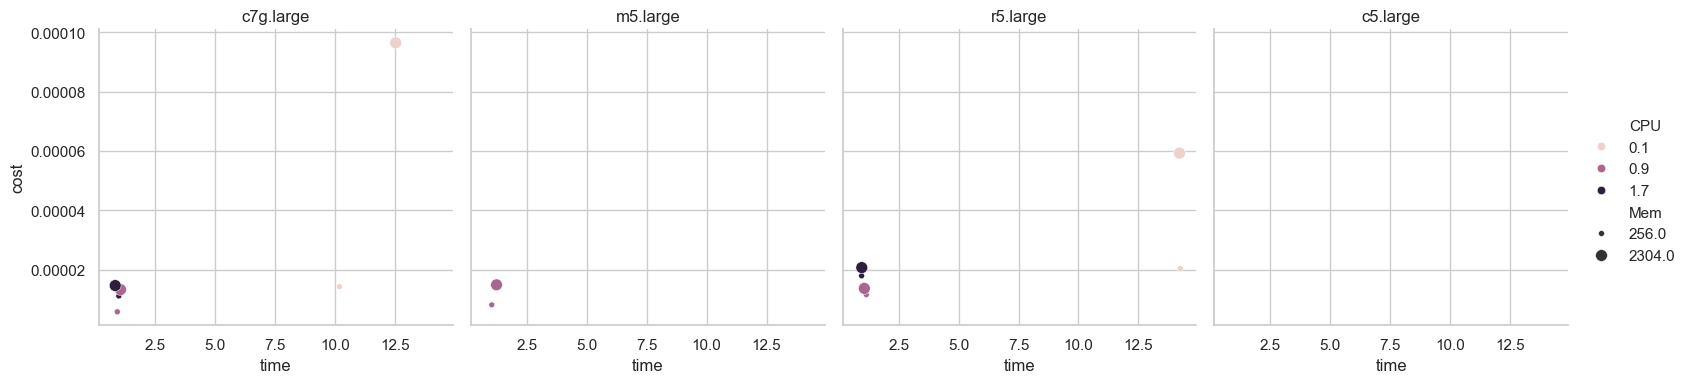

In [255]:
# Plot 2: time vs cost, 1 grid per NodeType
plt.figure(figsize=(12, 8))
scatter_by_node_type = sns.FacetGrid(df, col="NodeTypeStr", col_wrap=4, height=4)
scatter_by_node_type.map(sns.scatterplot, "time", "cost", hue="CPU", size="Mem", data=df)
scatter_by_node_type.set_titles("{col_name}")
scatter_by_node_type.add_legend()
plt.show()

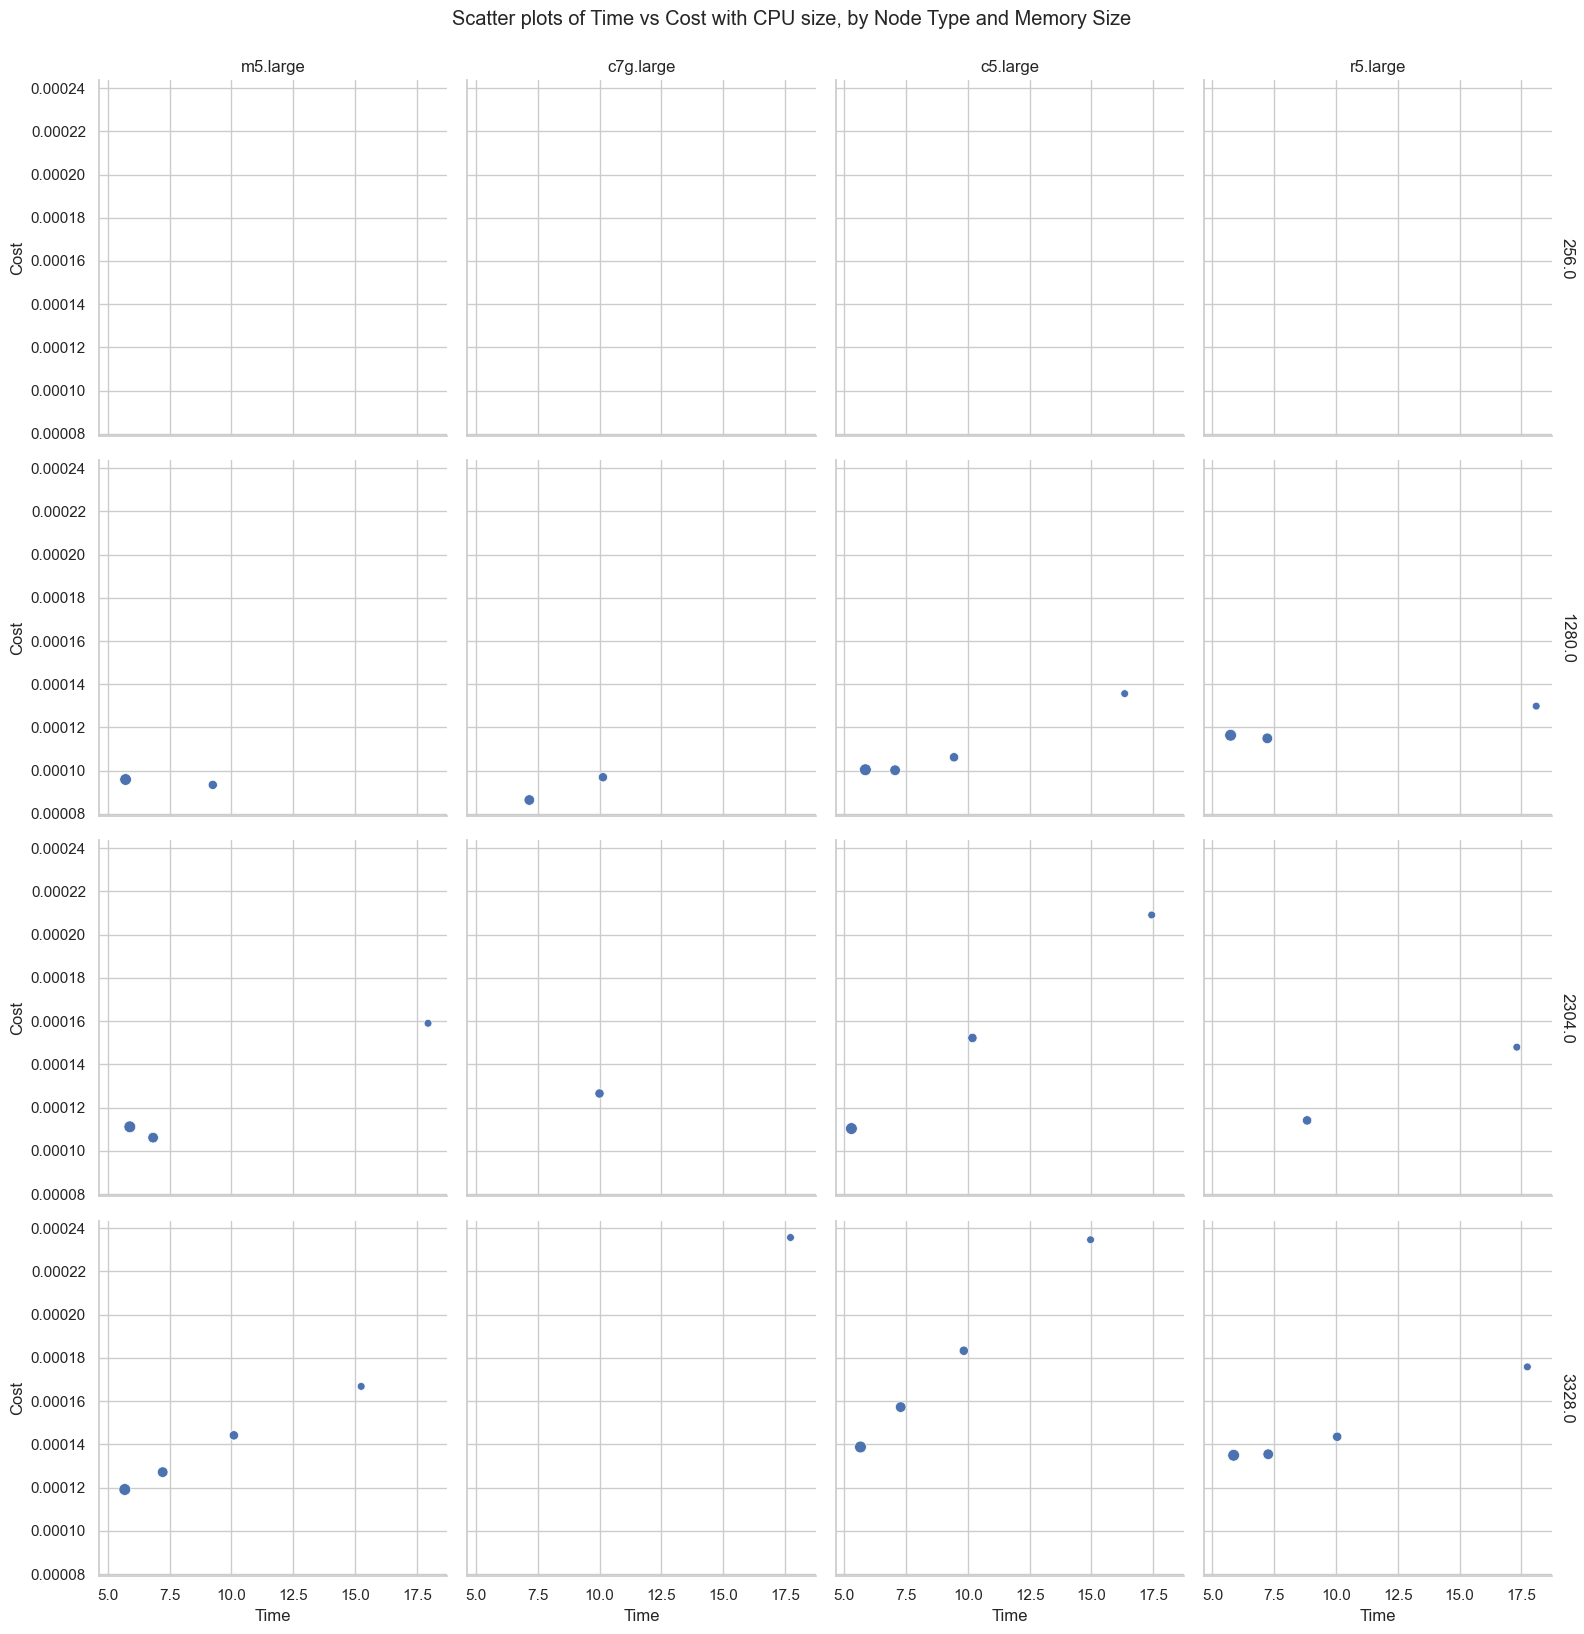

In [152]:
# Create a FacetGrid with node type on the x-axis and memory size on the y-axis
g = sns.FacetGrid(df, col="NodeTypeStr", row="Mem", margin_titles=True, height=4)

# Map scatter plots to each subplot
g.map(sns.scatterplot, "time", "cost", size="CPU", data=df)

# Adjust layout and add titles
g.set_axis_labels("Time", "Cost")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.fig.suptitle("Scatter plots of Time vs Cost with CPU size, by Node Type and Memory Size", y=1.02)

# Show the plot
plt.show()

In [122]:
def getRanges(start, end, num=10):
    step = (end-start)/num
    return np.arange(start, end, step)

def subSample(arr, rate=1):
    return arr[0::rate]

def npstr(arr):
    return ' '.join([f"{v:.5}" for v in arr])

In [123]:
allCpu = np.arange(.1,2,.1)
allMem = np.arange(.25,4,.25)*1024
allCpu,allMem, len(allCpu), len(allMem)

(array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
        1.4, 1.5, 1.6, 1.7, 1.8, 1.9]),
 array([ 256.,  512.,  768., 1024., 1280., 1536., 1792., 2048., 2304.,
        2560., 2816., 3072., 3328., 3584., 3840.]),
 19,
 15)

In [136]:
cpu = subSample(allCpu, 8)
cpu

array([0.1, 0.9, 1.7])

In [94]:
mem = getRanges(2**8, 2**10, 5)
mem

array([256. , 409.6, 563.2, 716.8, 870.4])

In [137]:
def getCommand(cpu, mem):
    return f"-c {npstr(cpu)} -m {npstr(mem)}"

In [140]:
def getCommands():
    for s in [1,2,4,8]:
        cpu = subSample(allCpu, s)
        mem = subSample(allMem, s)
        print(len(cpu),len(mem))
        yield getCommand(cpu,mem)

In [141]:
list(getCommands())

19 15
10 8
5 4
3 2


['-c 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 -m 256.0 512.0 768.0 1024.0 1280.0 1536.0 1792.0 2048.0 2304.0 2560.0 2816.0 3072.0 3328.0 3584.0 3840.0',
 '-c 0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5 1.7 1.9 -m 256.0 768.0 1280.0 1792.0 2304.0 2816.0 3328.0 3840.0',
 '-c 0.1 0.5 0.9 1.3 1.7 -m 256.0 1280.0 2304.0 3328.0',
 '-c 0.1 0.9 1.7 -m 256.0 2304.0']